
# Basketabll Activity Recognition using k-fold and LSTM Neural Network

# Reading the dataset

In [18]:
import pandas as pd
import numpy as np
import glob

import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score,confusion_matrix, plot_confusion_matrix
import time
from typing import Any
import torch
import torch.nn as nn

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from pandas import DataFrame
from keras.models import load_model

files = glob.glob('/data/shk/dl-for-har/tutorial_notebooks/Prof_New/*.csv')

name = [file.split('/')[-1] for file in files]
df = pd.concat(map(pd.read_csv,files),ignore_index = True) #4230213 rows × 10 columns

data = df

#Considering only basketball
clean_data = data[data['basketball']!='not_labeled']
clean_data = clean_data[data['basketball'].notna()]
clean_data['basketball'].replace({'jumping':'layup'},inplace=True) #Replacing jumping by layup

new_data = clean_data[clean_data.coarse != 'game'] #623758 rows × 10 columns
new_data = new_data.drop(columns='coarse')
new_data = new_data.iloc[:,:6]
print('new_data',new_data.shape)
print('____')

# Sepearting Game data from train data
game_data = clean_data[clean_data.coarse == 'game']
game_data = game_data.drop(columns='coarse')
game_data = game_data.iloc[:,:6] #45446 rows × 6 columns
print('game_data',game_data.shape)

/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


new_data (613454, 6)
____
game_data (45111, 6)


# Labelling the data

In [19]:
label = new_data['basketball']
x_axis = sorted(label.unique())
y_axis = label.value_counts()

X = new_data.iloc[:,:-1]#.astype(np.float32)

class_names = ['dribbling','shot','pass','layup','rebound']
num_classes = len(class_names)

def labelling(clean_data,data_y):
    clean_data[data_y == 'dribbling'] = 0
    clean_data[data_y == 'shot'] = 1
    clean_data[data_y == 'pass'] = 2
    clean_data[data_y == 'layup'] = 3
    clean_data[data_y == 'rebound'] = 4
    
    return data_y

y = labelling(new_data,new_data.iloc[:,-1]).astype(int)

#subject = X['subject']
#uni_subject = subject.unique()
#uni_subject_count = subject.value_counts()

data_labelled = np.concatenate((X, y[:,None]), axis=1)[:,1:] #669204, 6


/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Special preprocessing

In [20]:
data_bribbling = data_labelled[data_labelled[:,-1] == 0]
data_shot = data_labelled[data_labelled[:,-1] == 1]
data_pass = data_labelled[data_labelled[:,-1] == 2]
data_layup = data_labelled[data_labelled[:,-1] == 3]
data_rebound = data_labelled[data_labelled[:,-1] == 4]


def spilt(data):

    dd = np.asarray(data)
    T = int(0.8* len(dd))
    train_size = int(T)
    test_size = len(dd) - train_size

    train_df,test_df = torch.utils.data.random_split(dd, [train_size,test_size])
    X = train_df[:][:,0:4]
    Y = train_df[:][:,4]

    X_v = test_df[:][:,0:4]
    y_v = test_df[:][:,4]
  
    return X,Y,X_v,y_v

X_dribble,Y_dribble,X_v_dribble,y_v_dribble = spilt(data_bribbling)
X_shot,Y_shot,X_v_shot,y_v_shot = spilt(data_shot)
X_pass,Y_pass,X_v_pass,y_v_pass = spilt(data_pass)
X_layup,Y_layup,X_v_layup,y_v_layup = spilt(data_layup)
X_rebound,Y_rebound,X_v_rebound,y_v_rebound = spilt(data_rebound)

X = np.concatenate((X_dribble, X_shot,X_pass,X_layup,X_rebound), axis=0)[:,1:]
Y = np.concatenate((Y_dribble, Y_shot,Y_pass,Y_layup,Y_rebound), axis=0)

X_v = np.concatenate((X_v_dribble, X_v_shot,X_v_pass,X_v_layup,X_v_rebound), axis=0)[:,1:]
y_v = np.concatenate((y_v_dribble, y_v_shot,y_v_pass,y_v_layup,y_v_rebound), axis=0)

train_data = np.column_stack((X,Y))
valid_data = np.column_stack((X_v,y_v))

# Sliding Window

In [21]:
def sliding_window(data, samples_per_window, overlap_ratio):
    windows = []
    indices = []
    curr = 0
    win_len = int(samples_per_window)
    
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * (win_len))
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        windows.append(data[curr:curr + win_len])
        indices.append([curr, curr + win_len])
        curr = curr + win_len - overlapping_elements
    try:
        result_windows = np.array(windows)
        result_indices = np.array(indices)
    except:
        result_windows = np.empty(shape=(len(windows), win_len, data.shape[1]), dtype=object)
        result_indices = np.array(indices)
        for i in range(0, len(windows)):
            result_windows[i] = windows[i]
            result_indices[i] = indices[i]
    return result_windows, result_indices

def apply_sliding_window(data_x, data_y, sliding_window_size, sampling_rate, sliding_window_overlap):
    
    output_x, _ = sliding_window(data_x, sliding_window_size, sliding_window_overlap)
    output_y, _ = sliding_window(data_y, sliding_window_size, sliding_window_overlap)

    return output_x,output_y

sw_length = 50
sw_overlap = 25

X_train, y_train = apply_sliding_window(X, Y, sw_length, sampling_rate=50,sliding_window_overlap=sw_overlap)
X_valid, y_valid = apply_sliding_window(X_v, y_v, sw_length, sampling_rate=50,sliding_window_overlap=sw_overlap)


X_train, y_train = X_train.astype(np.float32), y_train.astype(np.uint8)
X_valid, y_valid = X_valid.astype(np.float32), y_valid.astype(np.uint8)

print("\nShape of the X_train and Y_train datasets after windowing: ")
print(X_train.shape, y_train.shape) 

print("\nShape of the X_valid and y_valid datasets after windowing: ")
print(X_valid.shape, y_valid.shape)

y_train = y_train[:,0]
y_valid = y_valid[:,0]

data_X = np.concatenate((X_train,X_valid),axis=0) 

print("\nShape of the X after windowing: ")
print(data_X.shape)

print("\nShape of the Y after windowing: ")
data_Y = np.concatenate((y_train,y_valid),axis=0) 
print(data_Y.shape)


Shape of the X_train and Y_train datasets after windowing: 
(12914, 50, 3) (12914, 50)

Shape of the X_valid and y_valid datasets after windowing: 
(3228, 50, 3) (3228, 50)

Shape of the X after windowing: 
(16142, 50, 3)

Shape of the Y after windowing: 
(16142,)


# Network

In [22]:
def Network(data_X, data_Y, k=10):
    
    fold = 1 
    train_preds = []
    train_gt = []
    test_preds = []
    test_gt = []   
    loss_acc = []
    c_matrix =[]
    perfold_f1_train = []
    perfold_f1_test = []
    skf = StratifiedKFold(n_splits=k,random_state=None, shuffle=False)

    for train_index, test_index in skf.split(data_X, data_Y):

        print('Current fold: ', fold)
        X_train, X_test = data_X[train_index], data_X[test_index]
        y_train, y_test = data_Y[train_index], data_Y[test_index]

        #Model architecture            
        model = Sequential()
        model.add(LSTM(units=26,input_shape=[X_train.shape[1], X_train.shape[2]], activation = 'relu', return_sequences = True))
        model.add(Dropout(rate=0.1))
        model.add(Flatten())
        model.add(Dense(units=150, activation='relu'))
        model.add(Dropout(rate=0.2))
        model.add(Dense(units=800, activation='relu'))
        model.add(Dropout(rate=0.3))
        model.add(Dense(units=5, activation='softmax'))

        #Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

        #Fit data to model
        model.fit(X_train,y_train,epochs=25, validation_data=(X_test,y_test),verbose=1)
        y_pred_train = np.argmax(model.predict(X_train), axis=-1)
        y_pred_test = np.argmax(model.predict(X_test), axis=-1)


        #Training
        acc_train = jaccard_score(y_train, y_pred_train, average='macro')
        pre_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
        reca_train = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
        f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

        train_preds = np.concatenate((np.array(train_preds, int), np.array(y_pred_train, int)))
        train_gt = np.concatenate((np.array(train_gt, int), np.array(y_train, int)))

        print("___Training____")
        print(f"accuracy {round(acc_train,3)*100} ,precision {round(pre_train,3)*100}, recall {round(reca_train,3)*100},f1_score {round(f1_train,3)*100} ")

        #Validation
        acc_test = jaccard_score(y_test, y_pred_test, average='macro')
        pre_test = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
        reca_test = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
        f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        test_preds = np.concatenate((np.array(test_preds, int), np.array(y_pred_test, int)))
        test_gt = np.concatenate((np.array(test_gt, int), np.array(y_test, int)))

        print("___Validation____")
        print(f"accuracy {round(acc_test,3)*100} ,precision {round(pre_test,3)*100}, recall {round(reca_test,3)*100}, f1_score {round(f1_test,3)*100} ")

        #Genarate Metrics
        loss_acc.append(model.evaluate(X_test,y_test))
        c_matrix.append(confusion_matrix(y_test, y_pred_test))
        perfold_f1_train.append(f1_train)
        perfold_f1_test.append(f1_test)
        fold+=1    

        #Save Weights
        model.save_weights('./Pre_Trained_models/test_data/test_data',overwrite=True)
        model.save('./Pre_Trained_models/test_data',overwrite=True)
        
    return train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,perfold_f1_train,perfold_f1_test

In [23]:
train_preds,train_gt,test_preds,test_gt,loss_acc,c_matrix,perfold_f1_train,perfold_f1_test = Network(data_X, data_Y)

Current fold:  1
Epoch 1/25
454/454 [==============================] - 6s 12ms/step - loss: 0.5059 - accuracy: 0.8383 - val_loss: 0.3581 - val_accuracy: 0.8836
Epoch 2/25
454/454 [==============================] - 5s 11ms/step - loss: 0.3140 - accuracy: 0.8928 - val_loss: 0.2620 - val_accuracy: 0.8954
Epoch 3/25
454/454 [==============================] - 5s 11ms/step - loss: 0.2546 - accuracy: 0.9100 - val_loss: 0.2946 - val_accuracy: 0.8991
Epoch 4/25
454/454 [==============================] - 5s 11ms/step - loss: 0.2136 - accuracy: 0.9230 - val_loss: 0.2007 - val_accuracy: 0.9226
Epoch 5/25
454/454 [==============================] - 5s 11ms/step - loss: 0.1886 - accuracy: 0.9318 - val_loss: 0.1891 - val_accuracy: 0.9263
Epoch 6/25
454/454 [==============================] - 5s 11ms/step - loss: 0.1709 - accuracy: 0.9391 - val_loss: 0.1671 - val_accuracy: 0.9399
Epoch 7/25
454/454 [==============================] - 5s 12ms/step - loss: 0.1609 - accuracy: 0.9422 - val_loss: 0.1464 - val

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  2
Epoch 1/25
454/454 [==============================] - 6s 12ms/step - loss: 0.5081 - accuracy: 0.8393 - val_loss: 0.3227 - val_accuracy: 0.8879
Epoch 2/25
454/454 [==============================] - 5s 12ms/step - loss: 0.3038 - accuracy: 0.8951 - val_loss: 0.3460 - val_accuracy: 0.8861
Epoch 3/25
454/454 [==============================] - 5s 12ms/step - loss: 0.2510 - accuracy: 0.9111 - val_loss: 0.2444 - val_accuracy: 0.9133
Epoch 4/25
454/454 [==============================] - 5s 11ms/step - loss: 0.2163 - accuracy: 0.9240 - val_loss: 0.2467 - val_accuracy: 0.9127
Epoch 5/25
454/454 [==============================] - 5s 11ms/step - loss: 0.1996 - accuracy: 0.9278 - val_loss: 0.2149 - val_accuracy: 0.9282
Epoch 6/25
454/454 [==============================] - 5s 11ms/step - loss: 0.1791 - accuracy: 0.9350 - val_loss: 0.2232 - val_accuracy: 0.9232
Epoch 7/25
454/454 [==============================] - 5s 11ms/step - loss: 0.1626 - accuracy: 0.9418 - val_loss: 0.2025 - val

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  3
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.5069 - accuracy: 0.8382 - val_loss: 0.3070 - val_accuracy: 0.8990
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.3046 - accuracy: 0.8952 - val_loss: 0.3412 - val_accuracy: 0.8872
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2497 - accuracy: 0.9120 - val_loss: 0.2047 - val_accuracy: 0.9263
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2193 - accuracy: 0.9215 - val_loss: 0.2262 - val_accuracy: 0.9133
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1985 - accuracy: 0.9291 - val_loss: 0.1718 - val_accuracy: 0.9374
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1795 - accuracy: 0.9381 - val_loss: 0.1701 - val_accuracy: 0.9356
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1706 - accuracy: 0.9399 - val_loss: 0.1766 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  4
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.4971 - accuracy: 0.8382 - val_loss: 0.3691 - val_accuracy: 0.8662
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.3058 - accuracy: 0.8923 - val_loss: 0.2732 - val_accuracy: 0.9120
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2489 - accuracy: 0.9128 - val_loss: 0.2142 - val_accuracy: 0.9281
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2115 - accuracy: 0.9254 - val_loss: 0.2409 - val_accuracy: 0.9157
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1877 - accuracy: 0.9336 - val_loss: 0.2090 - val_accuracy: 0.9238
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1797 - accuracy: 0.9369 - val_loss: 0.1907 - val_accuracy: 0.9306
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1746 - accuracy: 0.9381 - val_loss: 0.1977 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  5
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.5322 - accuracy: 0.8289 - val_loss: 0.3039 - val_accuracy: 0.9009
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.3066 - accuracy: 0.8955 - val_loss: 0.2523 - val_accuracy: 0.9120
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2534 - accuracy: 0.9104 - val_loss: 0.2047 - val_accuracy: 0.9281
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2217 - accuracy: 0.9218 - val_loss: 0.2394 - val_accuracy: 0.9145
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1921 - accuracy: 0.9312 - val_loss: 0.2154 - val_accuracy: 0.9287
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1761 - accuracy: 0.9362 - val_loss: 0.2065 - val_accuracy: 0.9275
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1721 - accuracy: 0.9395 - val_loss: 0.1761 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  6
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.4959 - accuracy: 0.8446 - val_loss: 0.2723 - val_accuracy: 0.9040
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2840 - accuracy: 0.9024 - val_loss: 0.2669 - val_accuracy: 0.8934
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2389 - accuracy: 0.9169 - val_loss: 0.2212 - val_accuracy: 0.9176
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2078 - accuracy: 0.9239 - val_loss: 0.1941 - val_accuracy: 0.9300
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1922 - accuracy: 0.9325 - val_loss: 0.2228 - val_accuracy: 0.9232
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1859 - accuracy: 0.9317 - val_loss: 0.1950 - val_accuracy: 0.9269
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1668 - accuracy: 0.9386 - val_loss: 0.1722 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  7
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.5034 - accuracy: 0.8385 - val_loss: 0.3118 - val_accuracy: 0.8903
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2968 - accuracy: 0.8998 - val_loss: 0.2766 - val_accuracy: 0.9064
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2358 - accuracy: 0.9169 - val_loss: 0.2343 - val_accuracy: 0.9176
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2035 - accuracy: 0.9261 - val_loss: 0.2201 - val_accuracy: 0.9151
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1815 - accuracy: 0.9340 - val_loss: 0.1835 - val_accuracy: 0.9281
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1680 - accuracy: 0.9394 - val_loss: 0.1759 - val_accuracy: 0.9294
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1525 - accuracy: 0.9450 - val_loss: 0.2383 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  8
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.4918 - accuracy: 0.8427 - val_loss: 0.2983 - val_accuracy: 0.8928
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.3011 - accuracy: 0.8952 - val_loss: 0.3127 - val_accuracy: 0.8903
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2520 - accuracy: 0.9107 - val_loss: 0.2211 - val_accuracy: 0.9195
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2200 - accuracy: 0.9207 - val_loss: 0.2417 - val_accuracy: 0.9102
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1974 - accuracy: 0.9292 - val_loss: 0.1870 - val_accuracy: 0.9287
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1809 - accuracy: 0.9353 - val_loss: 0.1966 - val_accuracy: 0.9281
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1686 - accuracy: 0.9391 - val_loss: 0.1643 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  9
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.5188 - accuracy: 0.8320 - val_loss: 0.3231 - val_accuracy: 0.8910
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2997 - accuracy: 0.8979 - val_loss: 0.3388 - val_accuracy: 0.8848
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2430 - accuracy: 0.9131 - val_loss: 0.2159 - val_accuracy: 0.9238
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2116 - accuracy: 0.9241 - val_loss: 0.2704 - val_accuracy: 0.9071
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1874 - accuracy: 0.9341 - val_loss: 0.2215 - val_accuracy: 0.9300
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1779 - accuracy: 0.9365 - val_loss: 0.1920 - val_accuracy: 0.9263
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1633 - accuracy: 0.9425 - val_loss: 0.2056 - val_accura

INFO:tensorflow:Assets written to: ./test_data/assets


Current fold:  10
Epoch 1/25
454/454 [==============================] - 5s 9ms/step - loss: 0.4970 - accuracy: 0.8415 - val_loss: 0.2957 - val_accuracy: 0.8891
Epoch 2/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2968 - accuracy: 0.8990 - val_loss: 0.2590 - val_accuracy: 0.8971
Epoch 3/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2430 - accuracy: 0.9118 - val_loss: 0.2043 - val_accuracy: 0.9275
Epoch 4/25
454/454 [==============================] - 4s 9ms/step - loss: 0.2162 - accuracy: 0.9235 - val_loss: 0.1748 - val_accuracy: 0.9331
Epoch 5/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1837 - accuracy: 0.9341 - val_loss: 0.2537 - val_accuracy: 0.9095
Epoch 6/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1752 - accuracy: 0.9361 - val_loss: 0.1679 - val_accuracy: 0.9436
Epoch 7/25
454/454 [==============================] - 4s 9ms/step - loss: 0.1580 - accuracy: 0.9428 - val_loss: 0.1519 - val_accur

INFO:tensorflow:Assets written to: ./test_data/assets


# Graph per fold

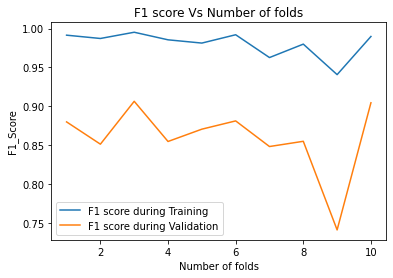

In [37]:

import matplotlib.pyplot as plt
k = 10
x_axis = [i+1 for i in range(k)]

plt.plot(x_axis, perfold_f1_train, label = "F1 score during Training")
plt.plot(x_axis, perfold_f1_test, label = "F1 score during Validation")
 
plt.xlabel('Number of folds')
plt.ylabel('F1_Score')
plt.title('F1 score Vs Number of folds')  
plt.legend()
plt.show()

# Predictions

In [26]:
cls = np.array(range(5))
class_names = ['dribbling','shot','pass','layup','rebound']

print('\nTraining RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(train_gt, train_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(train_gt, train_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(train_gt, train_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(train_gt, train_preds, average='macro')))

print("\nTraining RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(train_gt, train_preds, average=None, labels=cls)):
    print("   {0}: {1} %".format(class_names[i], rslt*100))


Training RESULTS: 

Avg. Accuracy: 0.9632997501715745
Avg. Precision: 0.9855384779123249
Avg. Recall: 0.9761983340967927
Avg. F1: 0.9808018493379562

Training RESULTS (PER CLASS): 

Accuracy:
   dribbling: 98.411945958758 %
   shot: 97.21902884983851 %
   pass: 87.85515819664784 %
   layup: 99.5752513096418 %
   rebound: 98.58849077090119 %

Precision:
   dribbling: 98.92599244895715 %
   shot: 99.2621988709407 %
   pass: 95.13733863923129 %
   layup: 99.77301744928359 %
   rebound: 99.67069154774973 %

Recall:
   dribbling: 99.47476087797867 %
   shot: 97.9266611524676 %
   pass: 91.98573573573574 %
   layup: 99.80133390095077 %
   rebound: 98.91067538126362 %

F1:
   dribbling: 99.19961772787002 %
   shot: 98.58990728918003 %
   pass: 93.534996898707 %
   layup: 99.78717366628831 %
   rebound: 99.28922908693275 %


# Validation Accuracies

In [27]:
print('\nValidation RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(test_gt, test_preds, average='macro')))
print("Avg. Precision: {0}".format(precision_score(test_gt, test_preds, average='macro')))
print("Avg. Recall: {0}".format(recall_score(test_gt, test_preds, average='macro')))
print("Avg. F1: {0}".format(f1_score(test_gt, test_preds, average='macro')))

print("\nVALIDATION RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(test_gt, test_preds, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))


Validation RESULTS: 

Avg. Accuracy: 0.7740772846064699
Avg. Precision: 0.8797915053489007
Avg. Recall: 0.8465506343076303
Avg. F1: 0.8623959050399865

VALIDATION RESULTS (PER CLASS): 

Accuracy:
dribbling: 93.0
shot: 86.0
pass: 52.0
layup: 92.0
rebound: 64.0

Precision:
dribbling: 96.0
shot: 94.0
pass: 71.0
layup: 96.0
rebound: 82.0

Recall:
dribbling: 97.0
shot: 91.0
pass: 66.0
layup: 96.0
rebound: 74.0

F1:
dribbling: 96.0
shot: 92.0
pass: 69.0
layup: 96.0
rebound: 78.0


In [28]:
print("\nGENERALIZATION GAP ANALYSIS: ")
print("\nTrain-Val-Accuracy Difference: {0}".format(jaccard_score(train_gt, train_preds, average='macro') -
                                                  jaccard_score(test_gt, test_preds, average='macro')))
print("Train-Val-Precision Difference: {0}".format(precision_score(train_gt, train_preds, average='macro') -
                                                   precision_score(test_gt, test_preds, average='macro')))
print("Train-Val-Recall Difference: {0}".format(recall_score(train_gt, train_preds, average='macro') -
                                                recall_score(test_gt, test_preds, average='macro')))
print("Train-Val-F1 Difference: {0}".format(f1_score(train_gt, train_preds, average='macro') -
                                            f1_score(test_gt, test_preds, average='macro')))


GENERALIZATION GAP ANALYSIS: 

Train-Val-Accuracy Difference: 0.1892224655651047
Train-Val-Precision Difference: 0.10574697256342414
Train-Val-Recall Difference: 0.12964769978916235
Train-Val-F1 Difference: 0.11840594429796969


# Testing on Game data

In [29]:
print('game_data',game_data.shape)

label_game = game_data['basketball']
x_axis_game = sorted(label_game.unique())
y_axis_game = label_game.value_counts()

X_game = game_data.iloc[:,:-1]

def labelling(clean_data,data_y):
    clean_data[data_y == 'dribbling'] = 0
    clean_data[data_y == 'shot'] = 1
    clean_data[data_y == 'pass'] = 2
    clean_data[data_y == 'layup'] = 3
    clean_data[data_y == 'rebound'] = 4
    
    return data_y

y_game = labelling(game_data,game_data.iloc[:,-1]).astype(int)

data_labelled_game = np.concatenate((X_game, y_game[:,None]), axis=1)[:,2:] #669204, 6
print('data_labelled_game ',data_labelled_game.shape)

data_labelled_X = data_labelled_game[:,:-1]
data_labelled_Y = data_labelled_game[:,-1]

print(data_labelled_X.shape,data_labelled_Y.shape)
sw_length = 50
sw_overlap = 25

X_train_game, y_train_game = apply_sliding_window(data_labelled_X, data_labelled_Y, sliding_window_size=sw_length, 
                                        sampling_rate=50,sliding_window_overlap=sw_overlap)


X_train_game, y_train_game = X_train_game.astype(np.float32), y_train_game[:,0].astype(np.uint8)

print("\nShape of the X_train_game and y_train_game datasets after windowing: ")
print(X_train_game.shape, y_train_game.shape)

game_data (45111, 6)
data_labelled_game  (45111, 4)
(45111, 3) (45111,)

Shape of the X_train_game and y_train_game datasets after windowing: 
(1186, 50, 3) (1186,)


/home/shk/anaconda3/envs/adversarial/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Loading the pretrained model

In [30]:
model = load_model('./Pre_Trained_models/test_data')

pt = './Pre_Trained_models/test_data/test_data'
model.load_weights(pt)

In [31]:
X_tt = data_X
y_tt = data_Y
loss_drill,acc_drill = model.evaluate(X_tt,y_tt)

print('___DRILL___')
print(f'DRILL_loss {round(loss_drill,3)}, Drill_accuracy {round(acc_drill,3)*100}')

#X_tt = data_X
#y_tt = data_Y
loss_game,acc_game = model.evaluate(X_train_game,y_train_game)

print('___GAME___')
print(f'GAME_loss {round(loss_game,3)}, GAME_accuracy {round(acc_game,3)*100}')

505/505 [==============================] - 2s 3ms/step - loss: 0.0392 - accuracy: 0.9885
___DRILL___
DRILL_loss 0.039, Drill_accuracy 98.8
38/38 [==============================] - 0s 3ms/step - loss: 32.8588 - accuracy: 0.2698
___GAME___
GAME_loss 32.859, GAME_accuracy 27.0


In [32]:
y_pred_game = np.argmax(model.predict(X_train_game), axis=-1)

#Training
acc_game = jaccard_score(y_train_game, y_pred_game, average='macro')
pre_game = precision_score(y_train_game, y_pred_game, average='macro', zero_division=0)
reca_game = recall_score(y_train_game, y_pred_game, average='macro', zero_division=0)
f1_game = f1_score(y_train_game, y_pred_game, average='macro', zero_division=0)

print("___GAME____")
print(f"accuracy {round(acc_game,3)*100} ,precision {round(pre_game,3)*100}, recall {round(reca_game,3)*100},f1_score {round(f1_game,3)*100} ")

___GAME____
accuracy 13.900000000000002 ,precision 25.6, recall 29.2,f1_score 23.799999999999997 


In [33]:
print('\nGame RESULTS: ')
print("\nAvg. Accuracy: {0}".format(jaccard_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Precision: {0}".format(precision_score(y_train_game, y_pred_game, average='macro')))
print("Avg. Recall: {0}".format(recall_score(y_train_game, y_pred_game, average='macro')))
print("Avg. F1: {0}".format(f1_score(y_train_game, y_pred_game, average='macro')))

print("\nGAME RESULTS (PER CLASS): ")
print("\nAccuracy:")
for i, rslt in enumerate(jaccard_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nPrecision:")
for i, rslt in enumerate(precision_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nRecall:")
for i, rslt in enumerate(recall_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))
print("\nF1:")
for i, rslt in enumerate(f1_score(y_train_game, y_pred_game, average=None, labels=cls)):
    print(f'{class_names[i]}: {round(rslt,2)*100}')
    #print("   {0}: {1} %".format(class_names[i], rslt*100))


Game RESULTS: 

Avg. Accuracy: 0.13851873835702838
Avg. Precision: 0.2555678282265573
Avg. Recall: 0.29186370483012064
Avg. F1: 0.23849890314398586

GAME RESULTS (PER CLASS): 

Accuracy:
dribbling: 24.0
shot: 11.0
pass: 8.0
layup: 18.0
rebound: 9.0

Precision:
dribbling: 51.0
shot: 14.000000000000002
pass: 27.0
layup: 21.0
rebound: 15.0

Recall:
dribbling: 31.0
shot: 33.0
pass: 10.0
layup: 54.0
rebound: 17.0

F1:
dribbling: 38.0
shot: 19.0
pass: 15.0
layup: 30.0
rebound: 16.0


# END